## Sentiment Anylisis Model Gift Cards
### COMP262 - Group 5
Juan Arevalo  
Jose Muniz  
Ruben Ormeno  
Samantha Ortiz de Foronda  
Mariela Ramos Vila


### 12.	Modeling (Sentiment Analysis) Machine Learning approach

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


C:\Users\maric\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Load data
df = pd.read_json(r"C:\MR\Centennial\Sem4\NLP\Project\part b\Gift_Cards.json",lines = True)

#### Field Description
overall (bigint) – User rating (1-5)  
verified (boolean)  Is the review verified (true, false)  
reviewtime (string) – Timestamp formatted like “10 30, 2009”  
reviewerid (string) – Amazon generated user id  
asin (string) – Unique Amazon generated product id  
reviewername (string) – User supplied name  
reviewtext (string) – Review text  
summary (string) – Summary of Review text  
unixreviewtime (bigint) – Timestamp formatted in epoch time  
vote (double) – Userful voters form other users  
style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"  
image -  images that users post after they have received the product  

In [3]:
# Base exploration
print('\n---Name and Types of colums---\n')
print(df.info())
print('\n---Shape----\n')
print(df.shape)



---Name and Types of colums---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147194 entries, 0 to 147193
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         147194 non-null  int64 
 1   vote            6341 non-null    object
 2   verified        147194 non-null  bool  
 3   reviewTime      147194 non-null  object
 4   reviewerID      147194 non-null  object
 5   asin            147194 non-null  object
 6   style           42375 non-null   object
 7   reviewerName    147190 non-null  object
 8   reviewText      147035 non-null  object
 9   summary         147154 non-null  object
 10  unixReviewTime  147194 non-null  int64 
 11  image           406 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 12.5+ MB
None

---Shape----

(147194, 12)


In [4]:
unique_overall_values = df['overall'].value_counts()
print("Number of unique 'overall' values:", len(unique_overall_values))
print("Counts of each unique 'overall' value:")
print(unique_overall_values)


Number of unique 'overall' values: 5
Counts of each unique 'overall' value:
overall
5    126689
4      8700
1      7165
3      2996
2      1644
Name: count, dtype: int64


### a.	Select a subset of the original data minimum 2000 reviews

In [5]:
# Select a Subset of Data
subset_data = df

In [6]:
# Subsampling of each rating category
subset_1 = subset_data[subset_data['overall'] == 1].sample(n=1400, replace=True, random_state=42)
subset_2 = subset_data[subset_data['overall'] == 2].sample(n=1400, replace=True, random_state=42)
subset_3 = subset_data[subset_data['overall'] == 3].sample(n=1400, replace=True, random_state=42)
subset_4 = subset_data[subset_data['overall'] == 4].sample(n=1400, replace=True, random_state=42)
subset_5 = subset_data[subset_data['overall'] == 5].sample(n=1400, replace=True, random_state=42)

# Combine the subsampled samples
subset_data = pd.concat([subset_1, subset_2, subset_3, subset_4, subset_5])

# Verify the balance of classes after manipulation
print(subset_data['overall'].value_counts())




overall
1    1400
2    1400
3    1400
4    1400
5    1400
Name: count, dtype: int64


### b. Carry out data exploration on the subset and pre-processing 

### b.1 Data exploration

In [7]:
# Base exploration
print('\n---Name and Types of colums---\n')
print(subset_data.info())
print('\n---Shape----\n')
print(subset_data.shape)


---Name and Types of colums---

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 23093 to 85176
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         7000 non-null   int64 
 1   vote            975 non-null    object
 2   verified        7000 non-null   bool  
 3   reviewTime      7000 non-null   object
 4   reviewerID      7000 non-null   object
 5   asin            7000 non-null   object
 6   style           1899 non-null   object
 7   reviewerName    7000 non-null   object
 8   reviewText      7000 non-null   object
 9   summary         6999 non-null   object
 10  unixReviewTime  7000 non-null   int64 
 11  image           72 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 663.1+ KB
None

---Shape----

(7000, 12)


In [8]:
# classes by variable
def check_columns(dataframe):
    total_counts = []
    unique_counts = []
    missing_values = []
    for column in dataframe.columns:
        try:
            # Attempt to count unique values in the usual way
            total_count = dataframe[column].count()
            unique_count = dataframe[column].nunique()
            missing_value = dataframe[column].isna().sum()
            
        except TypeError:
            # Handle unhashable items by converting them to strings (or another approach as needed)
            total_count = dataframe[column].astype(str).count()
            unique_count = dataframe[column].astype(str).nunique()
            missing_value = dataframe[column].astype(str).isna().sum() 
                
        total_counts.append(total_count)
        unique_counts.append(unique_count)
        missing_values.append(missing_value)

    # Create DataFrame with counts
    nunique_df = pd.DataFrame({'Column': dataframe.columns, 'Total counts': total_counts,'Unique Value': unique_counts, 'Missing values': missing_values})
    nunique_df = nunique_df.sort_values('Unique Value', ascending=False).reset_index(drop=True)
    return nunique_df
check_columns(subset_data)

,Column,Total counts,Unique Value,Missing values
0,reviewerID,7000,5919,0
1,reviewText,7000,5737,0
2,reviewerName,7000,5058,0
3,summary,6999,3836,1
4,reviewTime,7000,2003,0
5,unixReviewTime,7000,2003,0
6,asin,7000,796,0
7,vote,975,72,6025
8,image,7000,59,0
9,style,7000,30,0


In [9]:
# Select numerical variables

# Print summary statistics
print("\nCounts and Averages of Overall:")
print(subset_data['overall'].describe())




Counts and Averages of Overall:
count    7000.000000
mean        3.000000
std         1.414315
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: overall, dtype: float64


#### Distribution of number of reviews across products

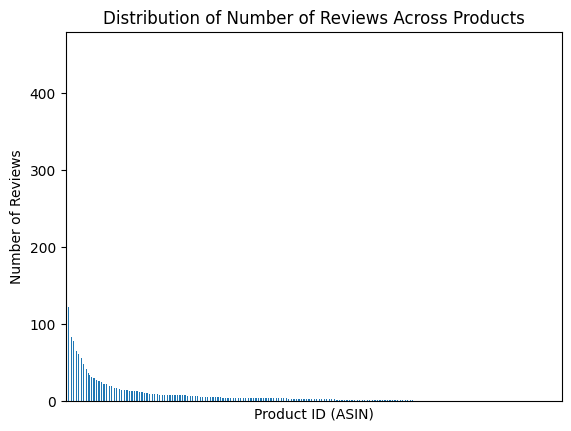

Maximum review count: 457


In [10]:
# Calculate the number of reviews per product (ASIN)
review_counts = subset_data['asin'].value_counts()

# Create the plot
#plt.figure(figsize=(10, 4))
review_counts.plot(kind='bar')
plt.title('Distribution of Number of Reviews Across Products')
plt.xlabel('Product ID (ASIN)')
plt.ylabel('Number of Reviews')
plt.xticks([])  # Rotate the x-axis labels for better readability
plt.show()

review_counts = subset_data['asin'].value_counts()
max_review_count = review_counts.max()

print("Maximum review count:", max_review_count)


#### Distribution of number of reviews per products

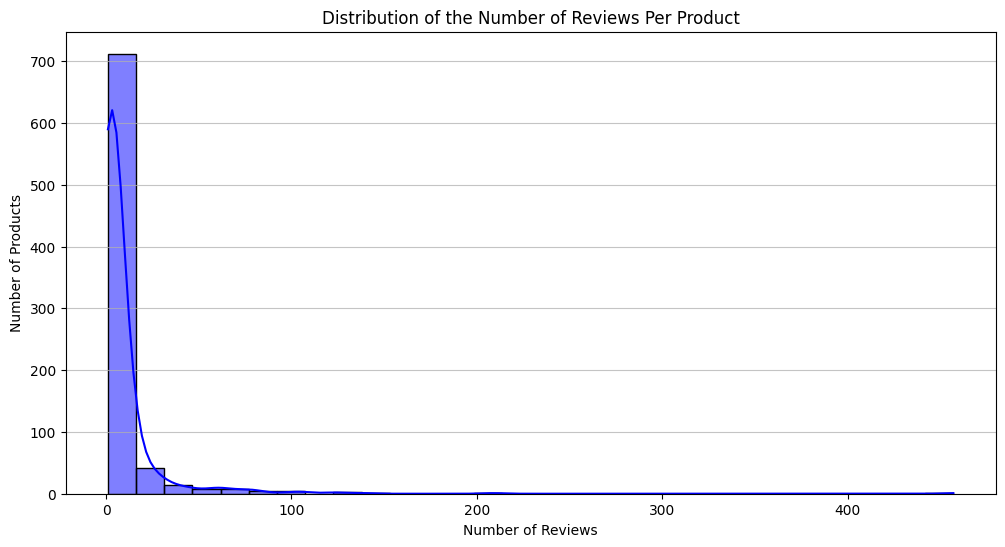

In [11]:
reviews_per_product = subset_data['asin'].value_counts()

# plot using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_product, bins=30, kde=True, color='blue')
plt.title('Distribution of the Number of Reviews Per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Products')
plt.grid(axis='y', alpha=0.75)

plt.show()


In [12]:
# Calculate the top 10 products with the most reviews and their counts
top_10_most_reviews = subset_data['asin'].value_counts().head(10)

print("Top 10 products with the most reviews:")
print(top_10_most_reviews)


Top 10 products with the most reviews:
asin
B004Q7CK9M    457
B004LLIKVU    209
B0091JKVU0    139
B00JDQJZWG    124
B0066AZGD4    123
B004LLIKY2    107
B0091JKY0M    106
B00ADR2XIC    102
B014S24DAI     96
B005ESMMWW     84
Name: count, dtype: int64


In [13]:
max_asin = top_10_most_reviews.index[0]  # maximum review count product
max_asin_reviews = subset_data[subset_data['asin'] == max_asin]['reviewText']

print("Reviews for product with ASIN", max_asin, ":", max_asin_reviews)

Reviews for product with ASIN B004Q7CK9M : 23093     Refund please since not applied by the recipient
30235    My gift receiver could not figure out who was ...
28087    Were is my 10 dollar credit? had a promotion b...
26217    Only by chance was the card found in its large...
31037    Follow up, the gift card finally arrived 4 day...
                               ...                        
26827    This is such an easy to gift a loved one! Beca...
28627    My son recently graduated from college and is ...
23791                                   Very easy present.
23230                   Perfect Christmas gift for my Dad!
30839    Fun to give these. The next-day shipping is nu...
Name: reviewText, Length: 457, dtype: object


#### Distribution reviews per user

In [14]:
# Calculate the number of reviews per user
reviews_per_user = subset_data['reviewerID'].value_counts()

# Calculate the maximum, minimum, and average number of reviews per user
max_reviews_per_user = reviews_per_user.max()
min_reviews_per_user = reviews_per_user.min()
avg_reviews_per_user = reviews_per_user.mean()

print("Maximum number of reviews per user:", max_reviews_per_user)
print("Minimum number of reviews per user:", min_reviews_per_user)
print("Average number of reviews per user:", avg_reviews_per_user)


Maximum number of reviews per user: 5
Minimum number of reviews per user: 1
Average number of reviews per user: 1.1826322013853692


#### Review lengths

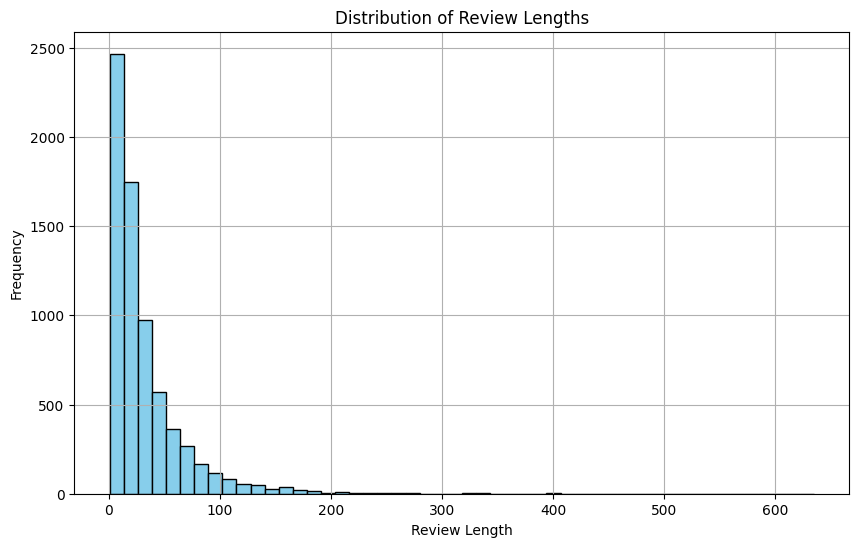

In [15]:
# Calculate review lengths
df_length = subset_data['reviewText'].dropna().apply(lambda x: len(str(x).split()))

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df_length, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Calculate maximum, minimum, and average review lengths
max_review_length = df_length.max()
min_review_length = df_length.min()
avg_review_length = df_length.mean()


In [16]:
# review lengths
print("Minimum review length:", df_length.min())
print("Maximum review length:", df_length.max())
print("Average review length:", df_length.mean())

Minimum review length: 1
Maximum review length: 635
Average review length: 31.79885714285714


### b.2 Pre-processing

In [17]:
# Labeling the data based on ratings
def label_rating(row):
    if row['overall'] >= 4:
        return 'positive'
    elif row['overall'] == 3:
        return 'neutral'
    else:  # Ratings 1 and 2
        return 'negative'

subset_data['rating_label'] = subset_data.apply(label_rating, axis=1)

#### Chose the appropriate columns for your sentiment analyzer

In [18]:
# Dropping columns 'image', 'vote', and 'style' columns because are not important for the analysis
subset_data.drop(columns=['image', 'vote', 'style'], inplace=True, errors='ignore')


# Dropping 'overall' because'rating_label' will be used
subset_data.drop(columns=['overall'], inplace=True)

# Dropping columns that are not important for Sentiment analysis
subset_data.drop(columns=['reviewerName', 'reviewerID', 'asin', 'unixReviewTime', 'reviewTime' ], inplace=True)

# Chose the appropriate columns for your sentiment analyzer
subset_data['reviewText'] = subset_data['reviewText'].fillna('')
subset_data['summary'] = subset_data['summary'].fillna('')

# Combine 'reviewText' and 'summary' into a single column for a comprehensive sentiment analysis
subset_data['combined_text'] = subset_data['reviewText'] + " " + subset_data['summary']

subset_data.drop(columns=['reviewText', 'summary'], inplace=True, errors='ignore')

# Print the shape of the DataFrame to see the number of entries and columns
print("DataFrame shape:", subset_data.shape)

subset_data.head()

DataFrame shape: (7000, 3)


,verified,rating_label,combined_text
23093,False,negative,Refund please since not applied by the recipie...
116922,True,negative,Worse service of my life ! And customer care i...
113944,True,negative,Someone hacked my account and ordered the gift...
113696,True,negative,DO NOT buy third party gift cards from Amazon....
88777,False,negative,I ran into this last Christmas when I received...


In [19]:
# Print a summary of any missing values in the combined_text column
print("\nMissing values in 'combined_text':", subset_data['combined_text'].isnull().sum())



Missing values in 'combined_text': 0


#### Check for outliers

#### Unverified Reviewers outliers

In [20]:
def identify_unverified_reviewers(df):
    unverified_reviewers = df[df['verified'] == False]
    df = df.drop(unverified_reviewers.index)
    return len(unverified_reviewers)


unverified_reviewers_count = identify_unverified_reviewers(subset_data)
print("Number of Unverified Reviewers:", unverified_reviewers_count)


Number of Unverified Reviewers: 847


In [21]:
# Delete unverified users reviews 
subset_data = subset_data[subset_data['verified'] != False]
subset_data.shape


(6153, 3)

In [22]:
# Drop column 'verified'
subset_data.drop(columns=['verified'], inplace=True, errors='ignore')
subset_data.shape

(6153, 2)

#### Word count outliers

Outlier threshold (Z-Score Method): 137.51721736213537


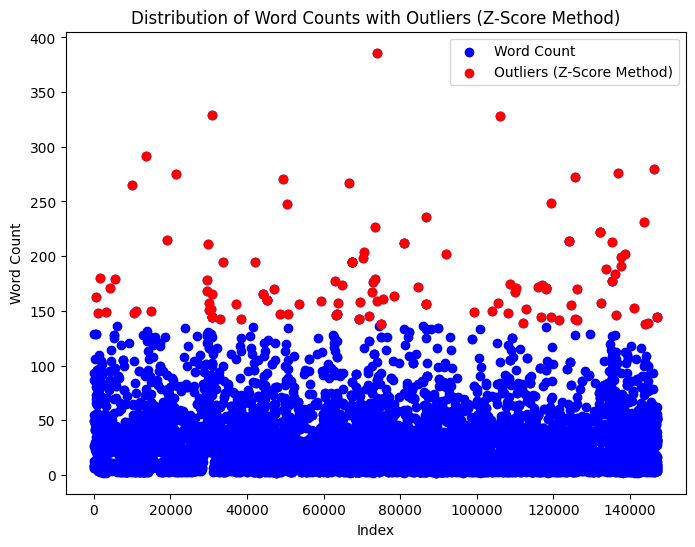

In [23]:
# Check for outliers in 'combined_text' by word count
subset_data['word_count'] = subset_data['combined_text'].fillna('').apply(lambda x: len(x.split()))

# Calculate z-scores
mean_length = subset_data['word_count'].mean()
std_length = subset_data['word_count'].std()

# Define threshold for outliers using z-scores
z_score_threshold = 3

# Print outlier threshold
outlier_threshold = mean_length + z_score_threshold * std_length
print("Outlier threshold (Z-Score Method):", outlier_threshold)

# Calculate z-scores for word count
wordcount_z_score = (subset_data['word_count'] - mean_length) / std_length

# Identify outliers using z-scores
outliers_z_score = subset_data['word_count'][(wordcount_z_score > z_score_threshold) | (wordcount_z_score < -z_score_threshold)]

# Create a scatter plot to visualize the distribution of review lengths and identify outliers using z-scores
plt.figure(figsize=(8, 6))
plt.scatter(subset_data['word_count'].index, subset_data['word_count'], c='blue', label='Word Count')
plt.scatter(outliers_z_score.index, outliers_z_score, c='red', label='Outliers (Z-Score Method)')
plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Distribution of Word Counts with Outliers (Z-Score Method)')
plt.legend()
plt.show()

In [24]:
# Filter rows where word count is less than or equal to 89 to delete oouliers
subset_data = subset_data[subset_data['word_count'] <= outlier_threshold]

# Drop the 'word_count' column as it's no longer needed
subset_data.drop(columns=['word_count'], inplace=True)

# Optionally, you can reset the index of the DataFrame after dropping rows
subset_data.reset_index(drop=True, inplace=True)

subset_data.shape

(6030, 2)

In [25]:
subset_data.head()

,rating_label,combined_text
0,negative,Worse service of my life ! And customer care i...
1,negative,Someone hacked my account and ordered the gift...
2,negative,DO NOT buy third party gift cards from Amazon....
3,negative,I returned the tv amplifier and according to m...
4,negative,Product came inactivated and in poor shape. Wo...


In [26]:
subset_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6030 entries, 0 to 6029
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating_label   6030 non-null   object
 1   combined_text  6030 non-null   object
dtypes: object(2)
memory usage: 94.3+ KB


#### Duplicates

In [27]:
# Find duplicates in the 'combined_text' column
duplicates_combinedText = subset_data[subset_data.duplicated(subset=['combined_text'], keep=False)]

# Count the number of duplicate rows based on specific columns
duplicate_count = duplicates_combinedText.shape[0]

print("Number of duplicate rows considering combined_text:", duplicate_count)


Number of duplicate rows considering combined_text: 1730


In [28]:
# Remove duplicates from subset_data based on the 'combined_text' column
subset_data = subset_data.drop_duplicates(subset=['combined_text'], keep='first')

# Verify the removal of duplicates
print("Number of rows after removing duplicates:", len(subset_data))


Number of rows after removing duplicates: 5044


C:\Users\maric\AppData\Local\Temp\ipykernel_36840\196748596.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='magma')


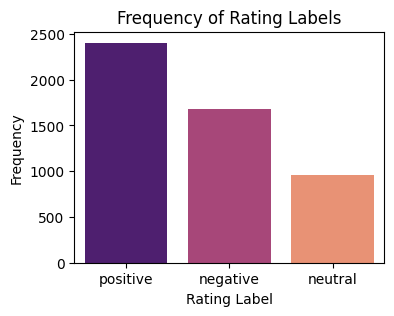

positive: 47.64%
negative: 33.33%
neutral: 19.03%
Shape of dataframe: (5044, 2)


In [29]:
# Count the frequency of each rating label
label_counts = subset_data['rating_label'].value_counts()

# Calculate percentage of each rating label
label_percentage = label_counts / len(subset_data) * 100

# Plot the frequency of each rating label using seaborn
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='magma')
plt.title('Frequency of Rating Labels')
plt.xlabel('Rating Label')
plt.ylabel('Frequency')

plt.show()


# Print the percentage for each rating label
for label, percentage in zip(label_percentage.index, label_percentage.values):
    print(f"{label}: {percentage:.2f}%")
# Print shape of dataframe
print("Shape of dataframe:", subset_data.shape)


In [30]:
# Load spaCy model for tokenization
nlp = spacy.load('en_core_web_sm')

# Define the list of stopwords and create the lemmatizer object
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text using spaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize each word
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


subset_data['reviews_after_preprocessing'] = subset_data['combined_text'].apply(preprocess_text)
subset_data['reviews_after_preprocessing'].head()

0    Worse service life ! customer care none existe...
1    Someone hacked account ordered gift card . Pur...
2    buy third party gift card Amazon . work , grea...
3    returned tv amplifier according mail receipt r...
4    Product came inactivated poor shape . Would re...
Name: reviews_after_preprocessing, dtype: object

### c. Split the data into 70% for training and 30% for testing,—Use stratified splitting based on the rating value field.

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

X = subset_data['reviews_after_preprocessing'].values
y = subset_data['rating_label'].values


# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Generate indices for splitting
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3530,) (3530,)
(1514,) (1514,)


### d.	Represent the text using one of the text represtations discussed in the course, make sure to note in your report why you chose that representation.

In [32]:
import numpy as np

# Function to load GloVe embeddings from file
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load GloVe embeddings (example file path)
glove_file_path = r"C:\MR\Centennial\Sem4\NLP\Lab 6\glove.6B\glove.6B.100d.txt" 
glove_embeddings = load_glove_embeddings(glove_file_path)

# Function to vectorize text using GloVe embeddings
def vectorize_text_with_glove(text, embeddings_index, embedding_dim):
    vectorized_text = []
    for sentence in text:
        sentence_vector = []
        for word in sentence.split():
            if word in embeddings_index:
                sentence_vector.append(embeddings_index[word])
        if sentence_vector:
            vectorized_text.append(np.mean(sentence_vector, axis=0))
        else:
            vectorized_text.append(np.zeros(embedding_dim))
    return np.array(vectorized_text)

embedding_dim = 100  # Assuming GloVe embeddings of dimension 100
X_train_textr = vectorize_text_with_glove(X_train, glove_embeddings, embedding_dim)
X_test_textr = vectorize_text_with_glove(X_test, glove_embeddings, embedding_dim)

print("Shape of X_train_textr:", X_train_textr.shape)
print("Shape of X_test_textr:", X_test_textr.shape)


Shape of X_train_textr: (3530, 100)
Shape of X_test_textr: (1514, 100)


### e.	Build two sentiment analysis models using 70% of the data. Choose two of the following Machine Learning algorithms to build and fine tune your models:

#### Logistic Regression 

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build and fine-tune sentiment analysis models
# Model 1: Logistic Regression
logreg = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
logreg.fit(X_train_textr, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_textr)



C:\Users\maric\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
import numpy as np
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)





Accuracy:  0.6083223249669749
AUC:  0.7605434892728815
Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.64      0.64       505
     neutral       0.30      0.42      0.35       288
    positive       0.78      0.66      0.72       721

    accuracy                           0.61      1514
   macro avg       0.57      0.57      0.57      1514
weighted avg       0.64      0.61      0.62      1514



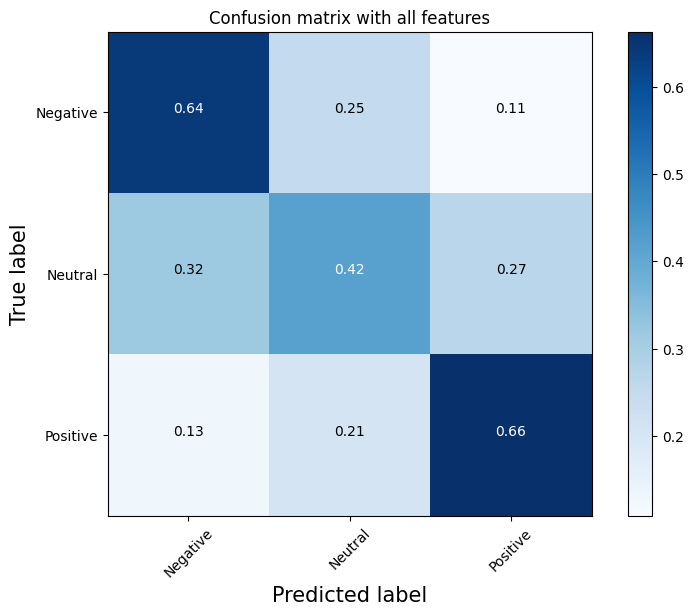

In [35]:
y_pred_prob = logreg.predict_proba(X_test_textr)

acc_lg_test = accuracy_score(y_test, y_pred_class)
#calculate evaluation measuresfor Logistic Regression
print("Accuracy: ", acc_lg_test)
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

#### Support Vector Machine (SVM):

Accuracy:  0.6261558784676354
AUC:  0.7848776313690907
Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.72      0.67       505
     neutral       0.30      0.35      0.32       288
    positive       0.82      0.67      0.74       721

    accuracy                           0.63      1514
   macro avg       0.58      0.58      0.58      1514
weighted avg       0.65      0.63      0.63      1514



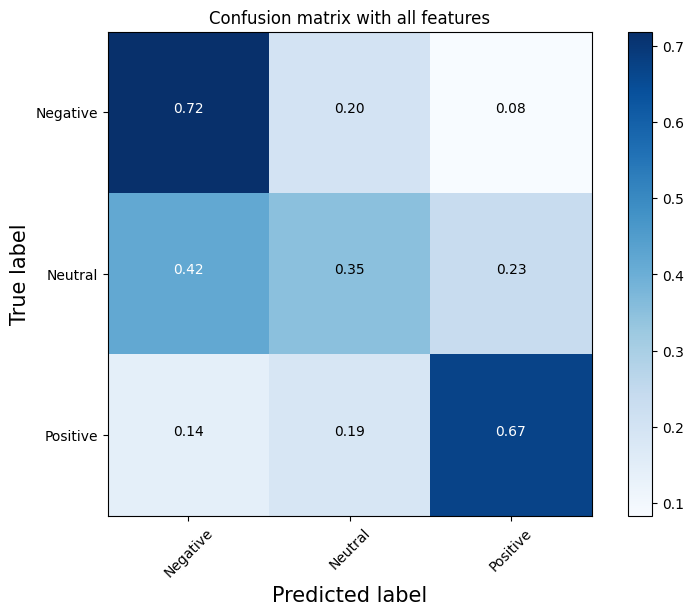

In [36]:
from sklearn.svm import SVC

# Instantiate the SVM model with 'rbf' kernel and class_weight='balanced'
svm = SVC(kernel='rbf', class_weight='balanced', probability=True)

# Fit the model with training data
svm.fit(X_train_textr, y_train)

# Make predictions on test data
y_pred_class = svm.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = svm.predict_proba(X_test_textr)

acc_SVM_test = accuracy_score(y_test, y_pred_class)
# Calculate evaluation measures:
print("Accuracy: ", acc_SVM_test)
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))

# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

#### Naive Bayes:

Accuracy:  0.4966974900924703
AUC:  0.6677225125236164
Classification Report:
              precision    recall  f1-score   support

    negative       0.43      0.81      0.56       505
     neutral       0.19      0.10      0.13       288
    positive       0.76      0.44      0.55       721

    accuracy                           0.50      1514
   macro avg       0.46      0.45      0.41      1514
weighted avg       0.54      0.50      0.48      1514



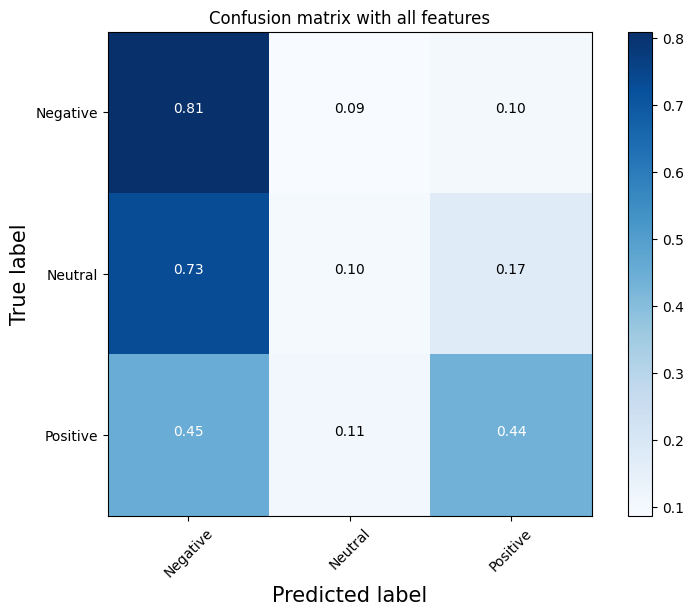

In [37]:

from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes classifier
gaussian_nb = GaussianNB()

# Train the model on the training data
gaussian_nb.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = gaussian_nb.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = gaussian_nb.predict_proba(X_test_textr)

acc_NB_test = accuracy_score(y_test, y_pred_class)
#calculate evaluation measures:
print("Accuracy: ", acc_NB_test)
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

#### Gradient Boosting: 

Accuracy:  0.6466314398943197
AUC:  0.7687427570652661
Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.74      0.66       505
     neutral       0.18      0.03      0.06       288
    positive       0.71      0.83      0.76       721

    accuracy                           0.65      1514
   macro avg       0.50      0.53      0.50      1514
weighted avg       0.57      0.65      0.60      1514



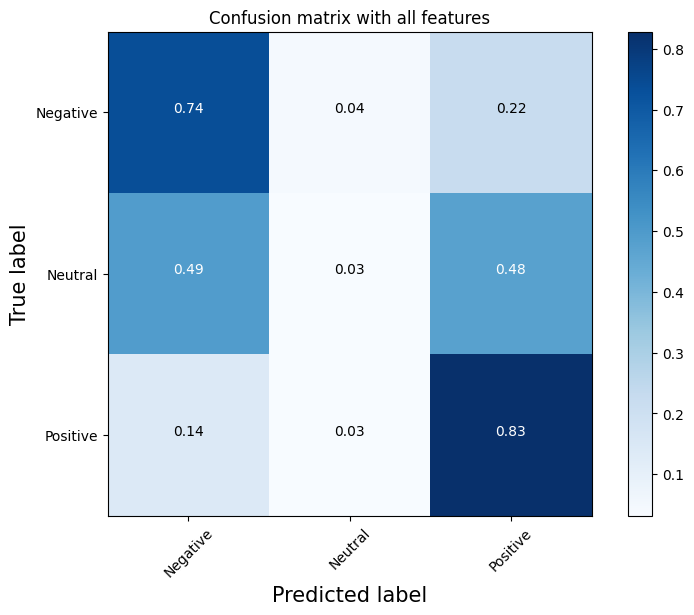

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gradient_boosting = GradientBoostingClassifier()

# Train the model on the training data
gradient_boosting.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = gradient_boosting.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = gradient_boosting.predict_proba(X_test_textr)

acc_GB_test = accuracy_score(y_test, y_pred_class)
#calculate evaluation measures:
print("Accuracy: ", acc_GB_test)
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')



#### Multi-layer Perceptron (MLP):

C:\Users\maric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  0.655217965653897
AUC:  0.7731607900350296
Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.75      0.67       505
     neutral       0.32      0.16      0.22       288
    positive       0.76      0.79      0.77       721

    accuracy                           0.66      1514
   macro avg       0.56      0.57      0.55      1514
weighted avg       0.63      0.66      0.63      1514



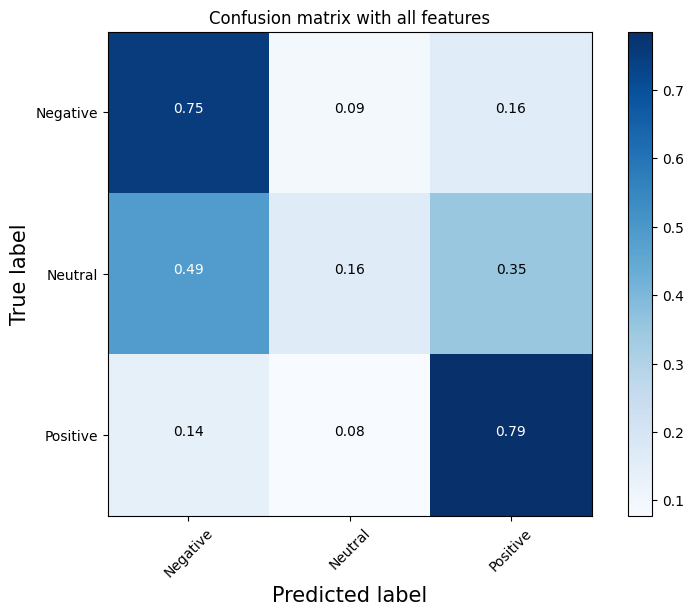

In [39]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP model
mlp_model = MLPClassifier()

# Train the model on the training data
mlp_model.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = mlp_model.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = mlp_model.predict_proba(X_test_textr)

acc_MLP_test = accuracy_score(y_test, y_pred_class)

#calculate evaluation measures:
print("Accuracy: ", acc_MLP_test)
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

In [40]:
print('\n=========================================')
print('ACCURACY OF MODELS WITH DATASET TESTING')
print("Accuracy Logistic Regresion: {:.2%}".format(acc_lg_test))
print("Accuracy SVM Model: {:.2%}".format(acc_SVM_test))
print("Accuracy Naive Bayes Model: {:.2%}".format(acc_NB_test))
print("Accuracy Gradient Boosting: {:.2%}".format(acc_GB_test))
print("Accuracy MLP: {:.2%}".format(acc_MLP_test))


ACCURACY OF MODELS WITH DATASET TESTING
Accuracy Logistic Regresion: 60.83%
Accuracy SVM Model: 62.62%
Accuracy Naive Bayes Model: 49.67%
Accuracy Gradient Boosting: 64.66%
Accuracy MLP: 65.52%


In [41]:
# Test texts
test_texts = [
    "This product is amazing!",
    "It is not bad",
    "I hate this product, it's terrible",
    " xxxx", 
    "This product is great!",
    "so so",
    "This product is not bad, but it could be better"
]

y_texts = [   
    "positive",
    "neutral",
    "negative",
    "neutral", 
    "positive",
    "neutral",
    "neutral"
    ]
# Preprocess the test texts
preprocessed_test_texts = [preprocess_text(text) for text in test_texts]

# Vectorize the preprocessed test texts using GloVe embeddings
X_test_vectorized = vectorize_text_with_glove(preprocessed_test_texts, glove_embeddings, embedding_dim)

# Test Logistic Regression model
print("Logistic Regression Model:")
# Make predictions
y_pred_logreg = logreg.predict(X_test_vectorized)
print("Predictions:", y_pred_logreg)
# Calculate accuracy
accuracy_logreg = accuracy_score(y_texts, y_pred_logreg)
print("Accuracy Logistic Regresion:", accuracy_logreg)

# Test SVM model
print("\nSVM Model:")
# Make predictions
y_pred_svm = svm.predict(X_test_vectorized)
print("Predictions:", y_pred_svm)
# Calculate accuracy
accuracy_svm = accuracy_score(y_texts, y_pred_svm)
print("Accuracy SVM Model:", accuracy_svm)

# Test Naive Bayes model
print("\nNaive Bayes Model:")
# Make predictions
y_pred_naive_bayes = gaussian_nb.predict(X_test_vectorized)
print("Predictions:", y_pred_naive_bayes)
# Calculate accuracy
accuracy_naive_bayes = accuracy_score(y_texts, y_pred_naive_bayes)
print("Accuracy Naive Bayes Model:", accuracy_naive_bayes)

# Test Gradient Boosting model
print("\nGradient Boosting Model:")
# Make predictions
y_pred_gradient_boosting = gradient_boosting.predict(X_test_vectorized)
print("Predictions:", y_pred_gradient_boosting)
# Calculate accuracy
accuracy_gradient_boosting = accuracy_score(y_texts, y_pred_gradient_boosting)
print("Accuracy Gradient Boosting:", accuracy_gradient_boosting)

# Test MLP model
print("\nMLP Model:")
# Make predictions
y_pred_mlp = mlp_model.predict(X_test_vectorized)
print("Predictions:", y_pred_mlp)
# Calculate accuracy
accuracy_mlp = accuracy_score(y_texts, y_pred_mlp)
print("Accuracy MLP:", accuracy_mlp)


import pickle
# Load the VADER model from the file
with open(r"C:\MR\Centennial\Sem4\NLP\Project\part b\models\vader_model_part1.pkl", 'rb') as f:
    vader_model = pickle.load(f)
      


# Test VADER model
print("VADER Model:")
y_pred_vader = []
for text in preprocessed_test_texts:
    score = vader_model.polarity_scores(text)['compound']
    if score > 0:
        print("positive")
        y_pred_vader.append('positive')
    elif score < 0:
        print("negative")
        y_pred_vader.append('negative')
    else:
        print("neutral")
        y_pred_vader.append('neutral')


# Calculate accuracy
accuracy_vader = accuracy_score(y_texts, y_pred_vader)
print("Accuracy VADER:", accuracy_vader)


Logistic Regression Model:
Predictions: ['positive' 'negative' 'neutral' 'neutral' 'positive' 'neutral' 'neutral']
Accuracy Logistic Regresion: 0.7142857142857143

SVM Model:
Predictions: ['positive' 'neutral' 'neutral' 'positive' 'positive' 'neutral' 'neutral']
Accuracy SVM Model: 0.7142857142857143

Naive Bayes Model:
Predictions: ['positive' 'positive' 'positive' 'positive' 'positive' 'neutral'
 'neutral']
Accuracy Naive Bayes Model: 0.5714285714285714

Gradient Boosting Model:
Predictions: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'negative']
Accuracy Gradient Boosting: 0.2857142857142857

MLP Model:
Predictions: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'negative']
Accuracy MLP: 0.2857142857142857
VADER Model:
positive
negative
negative
neutral
positive
neutral
negative
Accuracy VADER: 0.7142857142857143

Accuracy Logistic Regresion: 71.43%
Accuracy SVM Model: 71.43%
Accuracy Naive Bayes Model: 57.14%
Accuracy Gradient Boosting: 

In [42]:
#cOMPARE ACCUARACY
print('\n=========================================')
print("Accuracy Logistic Regresion: {:.2%}".format(accuracy_logreg))
print("Accuracy SVM Model: {:.2%}".format(accuracy_svm))
print("Accuracy Naive Bayes Model: {:.2%}".format(accuracy_naive_bayes))
print("Accuracy Gradient Boosting: {:.2%}".format(accuracy_gradient_boosting))
print("Accuracy MLP: {:.2%}".format(accuracy_mlp))
print("Accuracy VADER: {:.2%}".format(accuracy_vader))


Accuracy Logistic Regresion: 71.43%
Accuracy SVM Model: 71.43%
Accuracy Naive Bayes Model: 57.14%
Accuracy Gradient Boosting: 28.57%
Accuracy MLP: 28.57%
Accuracy VADER: 71.43%
